Reference:

John R. Ladd, Jessica Otis, Christopher N. Warren, and Scott Weingart, "Exploring and Analyzing Network Data with Python," The Programming Historian 6 (2017), https://doi.org/10.46430/phen0064.

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [1]:
from collections import Counter
import functools
import itertools
from operator import itemgetter
import re
import sys
from timeit import default_timer
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats

sys.path.append('../')
warnings.filterwarnings('ignore')

from sm_analysis.graph import *
from sm_analysis.time_series import *
from sm_analysis.topic_modeling import *
from sm_analysis.twitter.utils import *
from sm_analysis.utils import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

## Build User Graphs

### structure:
MultiDiGraph:
- nodes are userids $\rightarrow$ make nodes from unique ids
- edges are a tweet
- edges are directed (```user1``` ```-retweet>``` ```user2```)
- multiple edges between nodes (```user1``` retweeted ```user2``` multiple times)

In [3]:
def make_user_graph(campaign):
    
    unique_ids = dict(get_unique_ids(campaign, campaign_users))
    id_df = pd.DataFrame(data=unique_ids.values(),
                     index=unique_ids.keys(),
                     columns=['tweet_count'])
    id_df['in_campaign'] = (id_df.index).isin(campaign_users.index)

    user_graph = nx.Graph()
    user_nodes = user_graph.add_nodes_from(id_df.index, 
                            count=id_df.tweet_count, 
                            in_campaign=id_df.in_campaign,
                           )
    return user_graph
    
def make_connection_graph(tweetid, user1, user2, user_graph):

    graph = nx.MultiDiGraph(user_graph)

    tweetids = [dict(tweetid=tid) for tid in tweetid]
    graph.add_edges_from(list(zip(user1,
                                     user2,
                                     tweetids)))
    add_node_attributes(graph)
    
    return graph

In [4]:
fields = ['user_display_name',
       'user_reported_location',
       'user_profile_description',
       'follower_count',
       'following_count']

## Example: Iran 12/2020 Campaign

In [5]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
tweets_df = tweets.df.loc[:][:]
users_df = users.df.loc[:][:]
campaign = tweets_df[tweets_df['campaign'] == 'iran202012']
campaign_users = users_df[users_df['campaign'] == 'iran202012']

In [6]:
user_graph = make_user_graph(campaign)

In [7]:
retweets = (campaign
  .loc[:][['userid','retweet_userid']]
  .dropna()
  .reset_index()
 )
retweets['in_campaign'] = retweets['retweet_userid'].isin(campaign_users.index)

retweet_graph = make_connection_graph(retweets['tweetid'],
                                 retweets['userid'],
                                 retweets['retweet_userid'],
                                 user_graph)

In [8]:
replies = (campaign
          .loc[:][['userid', 'in_reply_to_userid']]
          .dropna()
          .reset_index()
         )

replies['in_campaign'] = replies['in_reply_to_userid'].isin(campaign_users.index)

reply_graph = make_connection_graph(replies['tweetid'],
                                    replies['userid'],
                                    replies['in_reply_to_userid'],
                                    user_graph)

In [9]:
mention_userids = (campaign['user_mentions']
            # expand usernames into columns
            .explode()
            # melt wide table into duplicated tweets
            .reset_index()
            .melt(id_vars=['tweetid'],
                  value_name='mentioned_userid')
            # clean up
            .astype({'mentioned_userid':'string'})
            .drop(columns=['variable'])
            .join(campaign['userid'], on='tweetid')
            .dropna()
          )
    
mentions = (mention_userids
            .loc[:][['userid','mentioned_userid','tweetid']]
            .query('mentioned_userid != ""')
           )

mentions['in_campaign'] = mentions['mentioned_userid'].isin(campaign_users.index)

mention_graph = make_connection_graph(mentions['tweetid'],
                                      mentions['userid'],
                                      mentions['mentioned_userid'],
                                      user_graph)

In [10]:
properties = graph_properties(retweet_graph)

Nodes: 61117
Edges: 17981
Maximum degree: 9737
Minimum degree: 0
Average degree: 0.6
Mode: 0


In [11]:
properties = graph_properties(reply_graph)

Nodes: 61117
Edges: 95096
Maximum degree: 13301
Minimum degree: 0
Average degree: 3.1
Mode: 0


In [12]:
properties = graph_properties(mention_graph)

Nodes: 61117
Edges: 288206
Maximum degree: 42752
Minimum degree: 0
Average degree: 9.4
Mode: 1


## Node degrees

In the user graphs, given that edges represent tweets, we can use the metric of node degree to understand how the users interacted with each other, with degree indicating tweet volume. The graphs are directed multigraphs, reflecting the fact that tweet relationships are directed (i.e. retweeting is different from being retweeted), and that a given user may have retweeted more than one of another user's tweets. As such, we make a distinction between incoming degree and outgoing degree.

In [13]:
def top_node_degrees(graph, limit=20):
    most_output = top_nodes(nx.get_node_attributes(graph, 'out_degree'),limit=limit)
    most_input = top_nodes(nx.get_node_attributes(graph, 'in_degree'),limit=limit)
    common_users = [userid for userid in dict(most_input).keys() 
                    if userid in dict(most_output).keys()]
    
    return most_output, most_input, common_users

### Retweets

In the case of retweets, we understand outgoing degrees as a measure of propagation of tweets, where a high outgoing degree indicates a high propagator role. A high incoming degree indicates that a user's content is highly propagated.

In [14]:
retweets['in_campaign'].value_counts()

True    17981
Name: in_campaign, dtype: int64

In [15]:
most_retweets, most_retweeted, common_rt = top_node_degrees(retweet_graph)

In [16]:
most_retweets

[('213589457', 4857),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 2025),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 1522),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 1453),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 1336),
 ('6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=', 649),
 ('794097607845015552', 625),
 ('QXyUcPxvoQ+uzkqCj6O+AT9nUf3Avh0JTvwTG9GncQk=', 581),
 ('A2ufeZxtC32uuqgSKfm1EiJPs4uMP3aM7AfHUMsTM=', 571),
 ('Hz3n1y2y3sLOknEGxPWczYyCSeZrz15JLPTcJAd6oAo=', 569),
 ('EOkiPW6kT+GE5A2wU5mqPe7hiK8s7Cr0tfCybFsz2Sg=', 523),
 ('ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=', 403),
 ('1091795789263921152', 371),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 293),
 ('LubegkQHPmV20BdQonItq03iWY5unAkvlI2M7PNKvjI=', 241),
 ('1067814896706994176', 211),
 ('xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=', 158),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 155),
 ('6UQXw4Mnf0c4YkJ5rSJWtgfZlNBQFdx38mOzYUt16sI=', 133),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 124)

In [17]:
most_retweeted

[('213589457', 4880),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 2623),
 ('1067814896706994176', 2407),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 1783),
 ('794097607845015552', 625),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 545),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 544),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 529),
 ('6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=', 505),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 445),
 ('1091795789263921152', 371),
 ('ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=', 366),
 ('mpY+AZI80Nu61VS3o4Zm+UXTjaxrkE08xU0nO3JQ=', 342),
 ('EOkiPW6kT+GE5A2wU5mqPe7hiK8s7Cr0tfCybFsz2Sg=', 299),
 ('1099221870530961408', 215),
 ('XCVp3AesS42sNbyxhBsKM62AylqUJyipi3laS53gY=', 168),
 ('6UQXw4Mnf0c4YkJ5rSJWtgfZlNBQFdx38mOzYUt16sI=', 133),
 ('QXyUcPxvoQ+uzkqCj6O+AT9nUf3Avh0JTvwTG9GncQk=', 133),
 ('xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=', 109),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 106)]

We see that most of the top 20 propagators and are also among the top 20 creators (as measured by retweet relationship):

In [18]:
len(campaign_users
 .loc[common_rt][fields]
)

17

In [19]:
(campaign_users
 .loc[common_rt][fields]
)

,user_display_name,user_reported_location,user_profile_description,follower_count,following_count
userid,,,,,
213589457,HispanTV,Teherán,"Medio no corporativo, que se hace eco de las r...",161512,31
Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=,Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=,<NA>,Freelance Journalist 📝 Middle-Eastern Politics...,2499,2701
1067814896706994176,Fatma Nursani,"Jakarta Barat, DKI Jakarta",أَمَّنْ يُجِيبُ الْمُضْطَرَّ إِذَا دَعَاهُ وَي...,5292,2384
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,Jakarta,"Pejuang keadilan 💪✊🇮🇩 Yang belum kefollow, in...",4436,2613
794097607845015552,Political Economy,<NA>,<NA>,5578,596
BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=,BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=,"Jakarta Selatan, DKI Jakarta",Account that fought for the oppressed countrie...,2485,1619
79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=,79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=,"Jakarta Selatan, DKI Jakarta",Indonesian 🇮🇩 😘 Middle Eastern Activist 💪🏻 Ant...,2536,2419
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,<NA>,in God we Trust,745,794
6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=,6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=,Indonesia,sharing my happy thoughts 🌹,584,383


### Replies

We can also observe replies as an indication of interactivity among campaign users. Further analysis could for instance identify and analyze chains of replies composing a conversation between a pair of users.

In [20]:
replies['in_campaign'].value_counts()

False    87913
True      7183
Name: in_campaign, dtype: int64

In [21]:
most_replying, most_replied, common_re = top_node_degrees(reply_graph)

In [22]:
most_replying

[('0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=', 13282),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 10258),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 8118),
 ('XpT328jUSYUJJM4Bt0HmKSJ8d8rJWgkBkQhdff62skE=', 6296),
 ('WFMM2eW8YAMex3B1z4P8vxx0OvkEJvFCx9l0uYGMqug=', 5969),
 ('1091795789263921152', 5086),
 ('1067814896706994176', 4852),
 ('wqcue0aByZjWGy2aKzh3IiKOK3urEeCGmRPpbpfvPBc=', 2703),
 ('1099221870530961408', 1832),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 1774),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 1746),
 ('mpY+AZI80Nu61VS3o4Zm+UXTjaxrkE08xU0nO3JQ=', 1427),
 ('DsqKOBIbyhdb1fRCREnRRabr2ijPMzNgximA+u8N8=', 1233),
 ('iVnWPNBGsoPoOI0d759LSmf2u0DGfCCHSznVuHLNjo=', 1218),
 ('lTQFNj2OGHS3yOz2SZimhktwdgrQmMsXUuaGHi7zek=', 1125),
 ('tfIRka6bXJoCm84UisMb2m4L8XpKyPJr7Yfv8UmeQ=', 1109),
 ('6UQXw4Mnf0c4YkJ5rSJWtgfZlNBQFdx38mOzYUt16sI=', 1075),
 ('5O68KDqdztRXhsl9HkNpWLfdwjINlgxlCDiKbBCFzzc=', 982),
 ('wBrHiyqOL5uBhytBGwy2W3A8nDXyRNfgAXfqXn3e0GY=', 982),
 ('eb

In [23]:
# most-replying user
most_re_userid = most_replying[0][0]

In [24]:
# account doesn't have much information -> look at tweets
(campaign_users
 .loc[most_re_userid][fields+['account_creation_date','account_language']]
)

user_display_name           0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=
user_reported_location                                              <NA>
user_profile_description                                            <NA>
follower_count                                                        68
following_count                                                       57
account_creation_date                                2013-02-27 00:00:00
account_language                                                      fa
Name: 0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=, dtype: object

In [25]:
most_re_user = (campaign
 .groupby('userid')
 .get_group(most_re_userid)
)

In [26]:
most_re_user[['tweet_text','hashtags','user_mentions']]

,tweet_text,hashtags,user_mentions
tweetid,,,
1315368545782566912,@VoteMarsha Why Women Prefer to Vote for an ra...,[],[63150856]
1266259765123923968,@SteveGelder After 20 years of screaming about...,[],[382340056]
1262005607655256065,@MrE1310 @JamesGRickards Only 14 billion usd o...,[],"[1247103535579197440, 93295809]"
1314411696308596738,@bfraser747 @realDonaldTrump @JoeBiden @Kamala...,[],"[274891222, 25073877, 939091, 30354991, 15..."
1303026114990870531,@BW Biden Immigration Amnesty Could Lead To As...,[],"[67358777, 3066129832]"
...,...,...,...
1265998829469433857,@RebeccaFlair @passport_cutty Silver is tradin...,[],"[285635271, 359416159]"
433672115108061185,اینترنت زغالی,NaN,[]
1312684338547482625,@king_Mulroney Vote biden = millions and milli...,[],[236273373]


In [27]:
most_re_user_timeline = make_timeline(most_re_user, 'd')

<IPython.core.display.Javascript object>


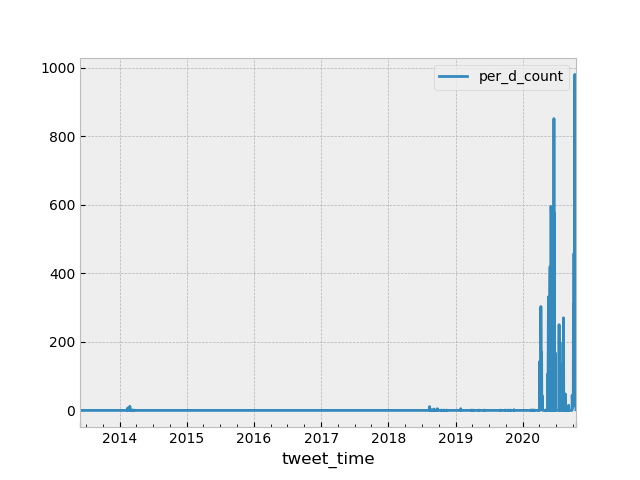

In [28]:
most_re_user_timeline.plot()

In [29]:
most_replied

[('25073877', 6440),
 ('759251', 5264),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 1686),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 1666),
 ('47448563', 693),
 ('EOkiPW6kT+GE5A2wU5mqPe7hiK8s7Cr0tfCybFsz2Sg=', 635),
 ('2467791', 608),
 ('2836421', 540),
 ('QXyUcPxvoQ+uzkqCj6O+AT9nUf3Avh0JTvwTG9GncQk=', 529),
 ('138212728', 513),
 ('790728', 487),
 ('410718052', 475),
 ('128262354', 420),
 ('irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8I=', 350),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 344),
 ('1285276850411864065', 316),
 ('5bXQzilfbR70wndojgGtIlSmUsL8W8RbAPssGLY0Y=', 302),
 ('1009577803304656896', 298),
 ('818910970567344128', 295),
 ('374729426', 291)]

In [30]:
(campaign_users
 .loc[common_re][fields]
)

,user_display_name,user_reported_location,user_profile_description,follower_count,following_count
userid,,,,,
rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=,rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=,<NA>,Treat others the way you'd like to be treated ...,2911,2441
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,<NA>,in God we Trust,745,794


### Mentions

Mentions can indicate an original message which is directed at the mentioned user, i.e. a tweet addressed to a user which is not specifically in reply to an existing tweet.

In [31]:
mentions['in_campaign'].value_counts()

False    278138
True      10068
Name: in_campaign, dtype: int64

In [32]:
most_mentions, most_mentioned, common_me = top_node_degrees(mention_graph)

In [33]:
most_mentions

[('213589457', 42752),
 ('1235289416370774016', 23375),
 ('0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=', 23120),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 22923),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 14665),
 ('1067814896706994176', 11811),
 ('WFMM2eW8YAMex3B1z4P8vxx0OvkEJvFCx9l0uYGMqug=', 8936),
 ('XpT328jUSYUJJM4Bt0HmKSJ8d8rJWgkBkQhdff62skE=', 8023),
 ('A8dbNc6R+dK0Ml02nrs1gjJKz9HIHRqLkcIixDiREoM=', 7997),
 ('1091795789263921152', 6760),
 ('fOKnPXaJon5pH9ZoHgWWQG+L1TdWue7y5OAPSPhLZs=', 5706),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 5413),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 5110),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 4412),
 ('6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=', 4296),
 ('ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=', 3923),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 3868),
 ('1099221870530961408', 3479),
 ('wqcue0aByZjWGy2aKzh3IiKOK3urEeCGmRPpbpfvPBc=', 3433),
 ('794097607845015552', 3380)]

In [34]:
most_mentioned

[('10228272', 34405),
 ('25073877', 7660),
 ('759251', 5409),
 ('irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8I=', 4901),
 (' 25073877', 3219),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 2744),
 ('5bXQzilfbR70wndojgGtIlSmUsL8W8RbAPssGLY0Y=', 2573),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 1964),
 ('1172112779815399424', 1759),
 ('1252764865', 1688),
 ('150573137', 976),
 ('1640929196', 727),
 ('47448563', 700),
 (' 939091', 694),
 ('1212304197627998209', 675),
 ('2467791', 647),
 ('1215636956291510274', 626),
 ('iMu6Ukwlry6PiiRnPSE710AKRlyOVlncYVaHAY9tRU4=', 625),
 ('1175350204628787200', 611),
 ('1009577803304656896', 601)]

In [35]:
(campaign_users
 .loc[common_me][fields]
)

,user_display_name,user_reported_location,user_profile_description,follower_count,following_count
userid,,,,,
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,Jakarta,"Pejuang keadilan 💪✊🇮🇩 Yang belum kefollow, in...",4436,2613


### Tweets containing the most-mentioned userid

In [36]:
uid = most_mentioned[0][0]
grouped = (mentions
            .groupby('mentioned_userid')['tweetid']
            .get_group(uid)
           )
grouped

4960      1218503009661083656
7964      1270109910685159425
26215     1316470583102787589
52187     1305082083635793921
80833     1117076730727026688
                 ...         
622541    1008526908592721920
622553     654081798763364352
622554    1019645770117632001
622556     962844249149538304
622560     948848104362663936
Name: tweetid, Length: 34405, dtype: int64

The most-mentioned user is YouTube:

In [37]:
(campaign[campaign.index.isin(grouped)][['tweet_text']]
 .iloc[0]
).to_list()

['I think medicine embargo is unacceptable, Because thousands of lives are at risk. US government must stop violation of human rights.\n#USA\n#Trump\n#HumanRights \n#Iran \nIran: Sanctions Threatening Health https://t.co/6QZ6T5CKfm via @YouTube']

## All connections

In [38]:
total_graph = nx.compose(reply_graph, retweet_graph)
total_graph = nx.compose(total_graph, mention_graph)

In [39]:
graph = nx.Graph(total_graph)
properties = graph_properties(graph)

Nodes: 61117
Edges: 76755
Maximum degree: 16259
Minimum degree: 0
Average degree: 2.5
Mode: 1


In [40]:
most_connected_uid = top_nodes(dict(graph.degree(graph.nodes())))[0][0]
campaign_users.loc[most_connected_uid]

user_display_name                0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=
user_screen_name                 0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=
user_reported_location                                                   <NA>
user_profile_description                                                 <NA>
user_profile_url                                                         <NA>
follower_count                                                             68
following_count                                                            57
account_creation_date                                     2013-02-27 00:00:00
account_language                                                           fa
file                        hashed_2020_12_iran_202012_iran_202012_users_c...
campaign                                                           iran202012
release                                                                202012
government                                                      

In [41]:
string_agg = lambda x: list(x)

user_tweets = (campaign
              .loc[campaign['userid'].isin(campaign_users.index)]
              .groupby('userid')['tweet_text']
              .agg(string_agg)
              )
mc_tweets = user_tweets.loc[most_connected_uid]
mc_tweets[:5]

['@VoteMarsha Why Women Prefer to Vote for an rapest Pedophile This is really worrying and encourages rape of women. Every vote for Biden\xa0 = Vote for women rape',
 '@SteveGelder After 20 years of screaming about the obvious manipulation of the Silver Price it looks like the DOJ &amp; CFTC just MIGHT stop "Allowing" it!!\n \nSoon...you will fondly remember the sub-$1,000oz. SILVER Days!!\n\nhttps://t.co/MAcg14YZRw',
 '@MrE1310 @JamesGRickards Only 14 billion usd of silver mine in one year and 180 billion usd of gold mine in one year . Silver mining down 60 percent in covid 19 lackdown and 65 percent of silver go to industrial and 25 percent go to jewelry only 10 percent go to investment silver price skyrocket soon',
 '@bfraser747 @realDonaldTrump @JoeBiden @KamalaHarris @SpeakerPelosi @POTUS Vote for hugo biden and in real hugo harris . Biden say anything hugo chavez say in 1998 .chavez win a fair election in 1998 and reach power by democracy . Taking money from the rich and distribu

In [42]:
len(mc_tweets)

13304

In [43]:
tokens = make_tokens(mc_tweets)
tokens[:2]

[['women',
  'prefer',
  'vote',
  'rapest',
  'pedophile',
  'really',
  'worrying',
  'encourages',
  'rape',
  'women',
  'every',
  'vote',
  'biden',
  'vote',
  'women',
  'rape'],
 ['years',
  'screaming',
  'obvious',
  'manipulation',
  'silver',
  'price',
  'looks',
  'like',
  'doj',
  'cftc',
  'might',
  'stop',
  'allowing',
  'soonyou',
  'fondly',
  'remember',
  'sub-oz',
  'silver',
  'days']]

In [44]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True)[:limit])
        
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

In [45]:
freq = word_frequency(long_list(tokens))

Word cloud of keywords from most-connected campaign user:

<IPython.core.display.Javascript object>


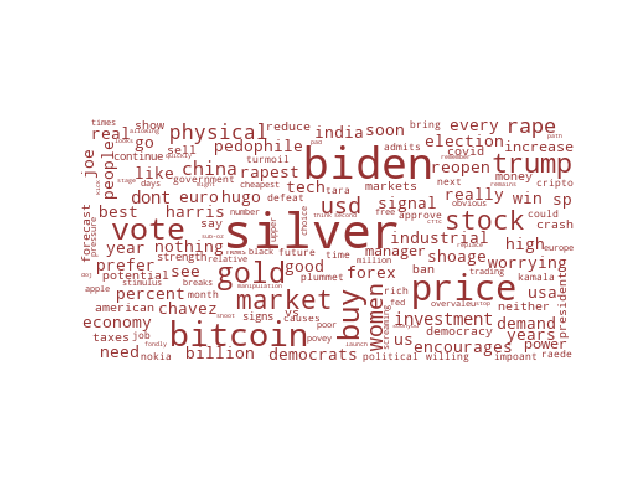

In [46]:
fig = visualize(freq, limit=150)

## Other
In addition to looking at the multigraph which considers tweet volume between users, we can collapse the multigraph to a digraph and consider simply the presence/absence of a directed relationship between users.

TODO: tweet volume as edge weight

### Connectivity: Density, clustering, transitivity

Measuring the tendency for nodes to cluster together or for edges to form triangles: this corresponds to measures of the extent to which the users interacting with one particular user tend to interact with each other as well. These metrics can provide insight into how users tend to create groups characterized by dense connections.

- Density describes the ratio of graph edges to the number of edges if the graph were fully connected.

- The clustering coefficient is calculated as the number of triangles connected to node $i$ divided by the number of sets of two edges connected to node $i$ (node triples). 

- The transitivity coefficient is calculated as 3 times the number of triangles in the network, divided by the number of connected triples of nodes in the network. Transitivity weights nodes with a large degree higher.

In [47]:
# not defined for MultiDiGraph
digraph = nx.DiGraph(retweet_graph)

In [48]:
print('Retweets:')
out = 'Density: {}'.format(nx.density(digraph))
print(out)
out = "Average clustering coefficient: {}".format(nx.average_clustering(digraph))
print(out)
out = "Transitivity: {}".format(nx.transitivity(digraph))
print(out)

Retweets:
Density: 8.540311915515041e-08
Average clustering coefficient: 0.00037529907717083943
Transitivity: 0.6254199328107503


### Undirected attributes
A further reduction is to consider the presence/absence of connection between users without making the directed distinction between propagator/propagated:

In [49]:
def add_undirected_attributes(G):
    
    G.graph['connected_components'] = nx.number_connected_components(graph)
    
    clustering_coeffs = nx.clustering(graph)
    G.graph['avg_clust'] = (sum(clustering_coeffs.values()) 
                             / len(clustering_coeffs)) 

In [50]:
# not defined for DiGraph
graph = nx.Graph(digraph)
add_undirected_attributes(graph)

In [51]:
out = 'Connected components: {}'.format(nx.number_connected_components(graph))
print(out)

clustering_coeffs = nx.clustering(graph)
out = 'Avg. clustering coefficient: {}'.format(sum(clustering_coeffs.values()) 
                             / len(clustering_coeffs))
print(out)

Connected components: 61056
Avg. clustering coefficient: 0.0004933720185999085


### Centrality

Capture the importance of a node's position in the network considering: 
- degree, on the assumption that an important node will have many connections
- closeness, on the assumption that important nodes are close to other nodes

In [52]:
graph_centrality = nx.degree_centrality(graph)
sorted(graph_centrality.items(), 
       key=lambda item: item[1],
       reverse=True)[:5]

[('v6groR3jb3Pkm5X9ccSwgoPnmlZzKEkx5bsc1XQHb0=', 0.0003108842201714772),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 0.00027815956541658485),
 ('1067814896706994176', 0.00026179723803913867),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 0.00026179723803913867),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 0.00026179723803913867)]

In [53]:
graph_closeness = nx.closeness_centrality(graph)
sorted(graph_closeness.items(),
       key=lambda item: item[1],
       reverse=True)[:5]

[('y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=', 0.00033293176299362923),
 ('wBrHiyqOL5uBhytBGwy2W3A8nDXyRNfgAXfqXn3e0GY=', 0.0003220159674856414),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 0.00029989273307823094),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 0.00029762081843369886),
 ('v6groR3jb3Pkm5X9ccSwgoPnmlZzKEkx5bsc1XQHb0=', 0.0002931787166660317)]

## To do
- In general, these measures show the sparsity of direct tweet connections among users in the total user graph. Further analysis could search for denser subsets of the overall graph.
- Beyond identifying the most active users in both directions, further analysis can apply topic and sentiment analysis to the tweets of top propagators and creators, to see e.g. what messages the campaign was emphasizing by retweeting itself